In [1]:
import numpy as np
import pandas as pd
import os
import re
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Activation, Dropout, Flatten, Dense, Input, Layer
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['font.size'] = 16

In [2]:
img_path = '/kaggle/input/fashion-product-images-dataset/fashion-dataset/images'
img_df = pd.read_csv('/kaggle/input/fashion-product-images-dataset/fashion-dataset/images.csv')
styles_df = pd.read_csv('/kaggle/input/fashion-product-images-dataset/fashion-dataset/styles.csv', on_bad_lines='skip')

In [3]:
img_df.head()

,filename,link
0,15970.jpg,http://assets.myntassets.com/v1/images/style/p...
1,39386.jpg,http://assets.myntassets.com/v1/images/style/p...
2,59263.jpg,http://assets.myntassets.com/v1/images/style/p...
3,21379.jpg,http://assets.myntassets.com/v1/images/style/p...
4,53759.jpg,http://assets.myntassets.com/v1/images/style/p...


In [4]:
styles_df.head()

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt


In [5]:
styles_df['filename'] = styles_df['id'].astype(str) + '.jpg'

In [6]:
styles_df

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,filename
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt,15970.jpg
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans,39386.jpg
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch,59263.jpg
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants,21379.jpg
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt,53759.jpg
...,...,...,...,...,...,...,...,...,...,...,...
44419,17036,Men,Footwear,Shoes,Casual Shoes,White,Summer,2013.0,Casual,Gas Men Caddy Casual Shoe,17036.jpg
44420,6461,Men,Footwear,Flip Flops,Flip Flops,Red,Summer,2011.0,Casual,Lotto Men's Soccer Track Flip Flop,6461.jpg
44421,18842,Men,Apparel,Topwear,Tshirts,Blue,Fall,2011.0,Casual,Puma Men Graphic Stellar Blue Tshirt,18842.jpg
44422,46694,Women,Personal Care,Fragrance,Perfume and Body Mist,Blue,Spring,2017.0,Casual,Rasasi Women Blue Lady Perfume,46694.jpg


In [7]:
img_files = os.listdir(img_path)

In [8]:
styles_df['present'] = styles_df['filename'].apply(lambda x:x in img_files)

In [9]:
styles_df = styles_df[styles_df['present']].reset_index(drop=True)

In [10]:
styles_df = styles_df.sample(10000)

In [11]:
img_size = 224

datagen = ImageDataGenerator(rescale=1/255.)

generator = datagen.flow_from_dataframe(dataframe = styles_df,
                                       directory = img_path,
                                       target_size = (img_size,img_size),
                                       x_col = 'filename',
                                       class_mode = None,
                                       batch_size = 32,
                                       shuffle = False,
                                       classes= None)

Found 10000 validated image filenames.


In [12]:
base_model = VGG16(include_top=False, input_shape= (img_size,img_size,3))

for layer in base_model.layers:
    layer.trainable = False
    
    
input_layer = Input(shape=(img_size,img_size,3))
x= base_model(input_layer)
output= GlobalAveragePooling2D()(x)

embeddings = Model(inputs = input_layer, outputs= output)
embeddings.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
Total params: 14,714,688
Trainable params: 0
Non-trainable params: 14,714,688
_________________________________________________________________


In [13]:
X = embeddings.predict(generator, verbose=1)

313/313 [==============================] - 431s 1s/step


# PCA

In [14]:
from sklearn.decomposition import PCA

In [15]:
pca = PCA(2)
X_pca = pca.fit_transform(X)

In [16]:
styles_df[['pc1', 'pc2']] = X_pca

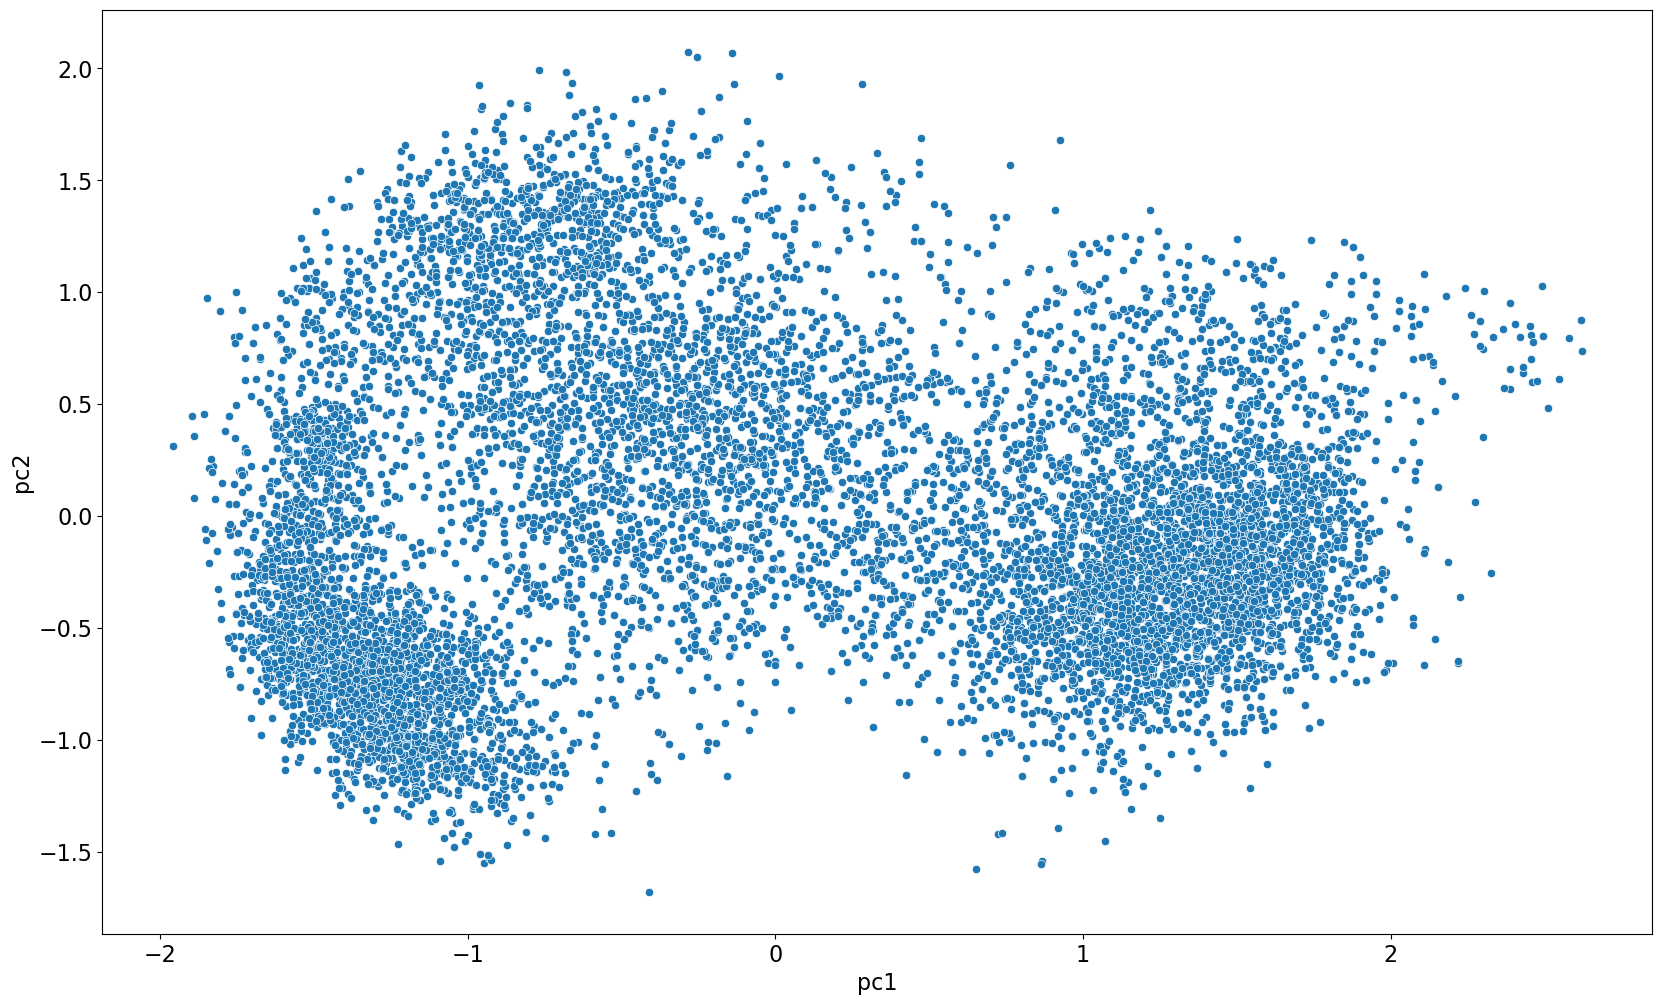

In [17]:
plt.figure(figsize= (20,12))
sns.scatterplot(x='pc1',y='pc2',data = styles_df)
plt.show()

In [18]:
def read_img(image_path):
    image = load_img(os.path.join(img_path,image_path),target_size=(img_size,img_size,3))
    image = img_to_array(image)
    image = image/255.
    return image

In [19]:
import random
from sklearn.neighbors import KNeighborsClassifier

In [20]:
y = styles_df['id']

In [21]:
nearest_neighbors = KNeighborsClassifier(n_neighbors = 7)
nearest_neighbors.fit(X,y)

KNeighborsClassifier(n_neighbors=7)

In [22]:
styles_df = styles_df.reset_index(drop=True)

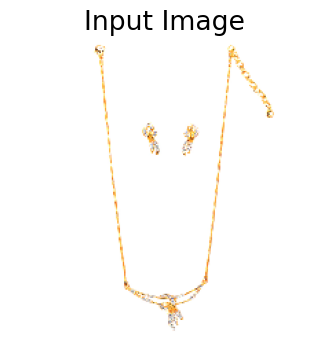

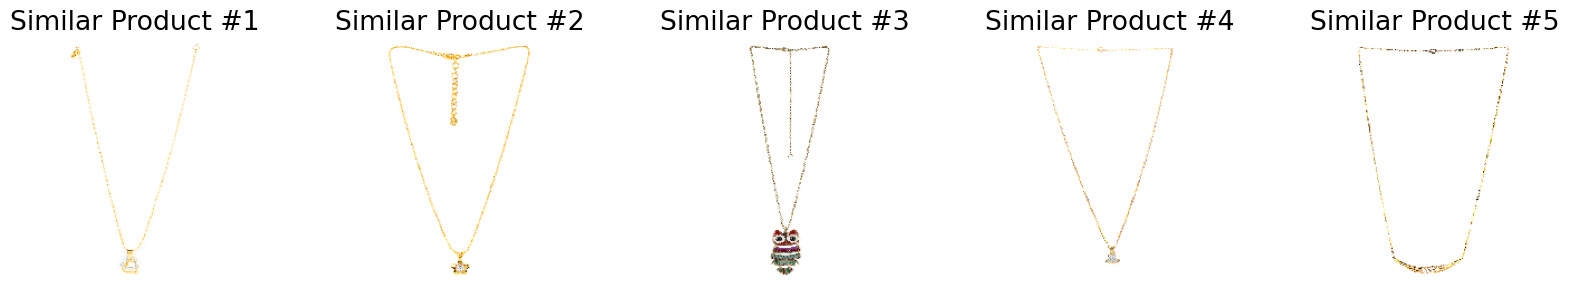

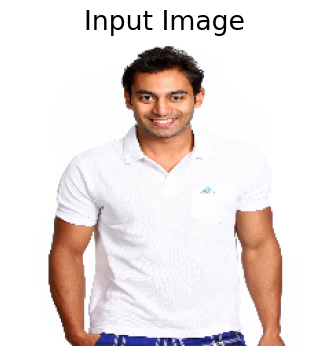

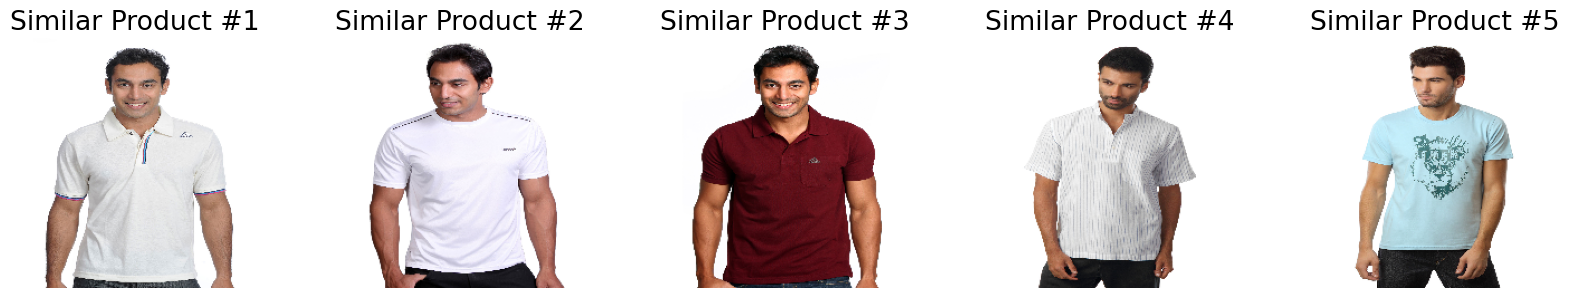

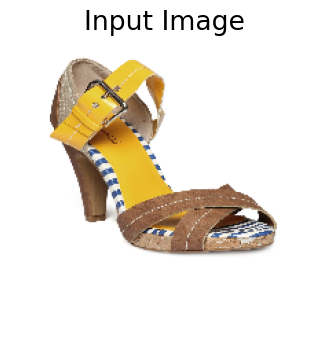

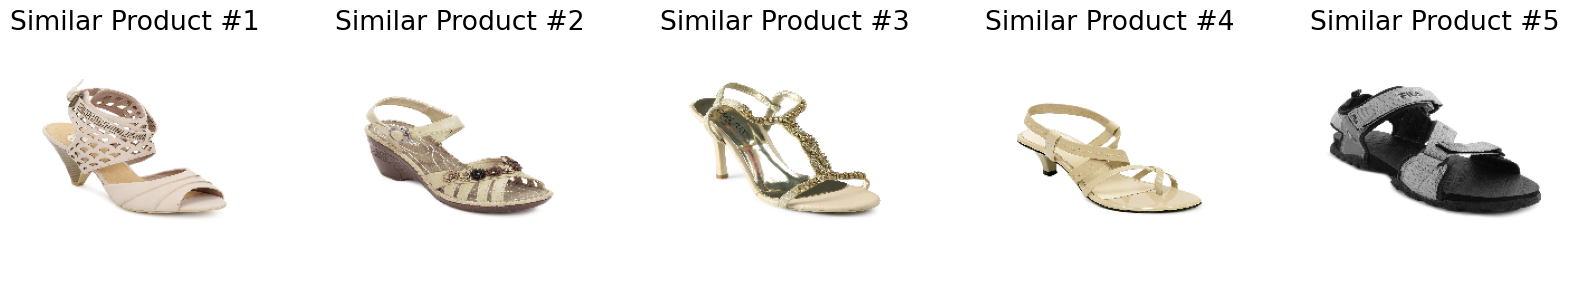

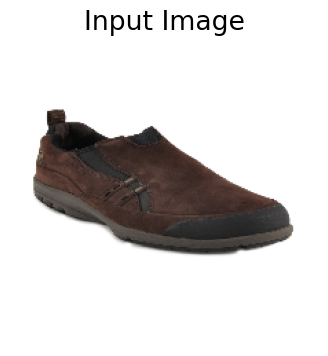

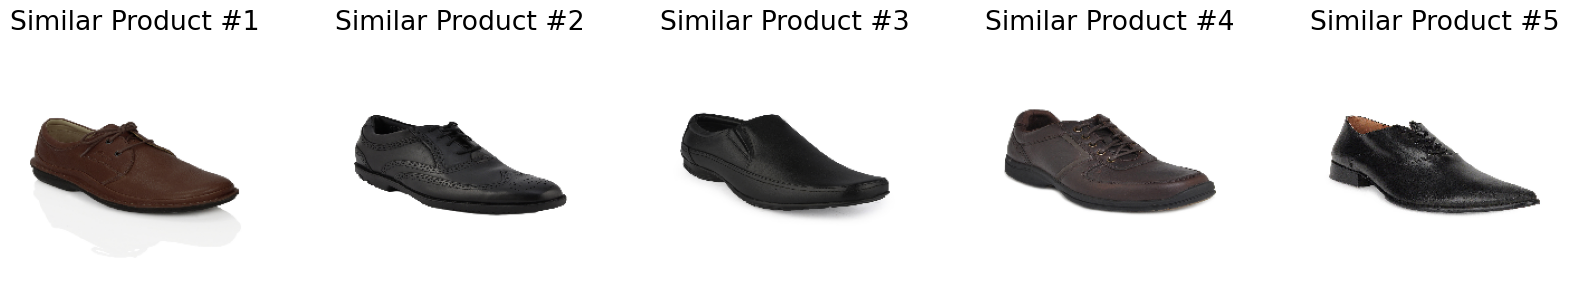

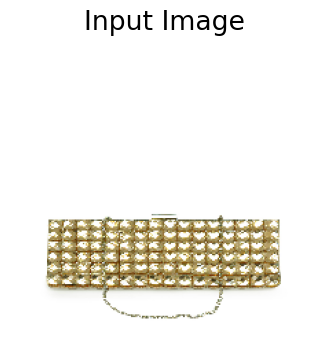

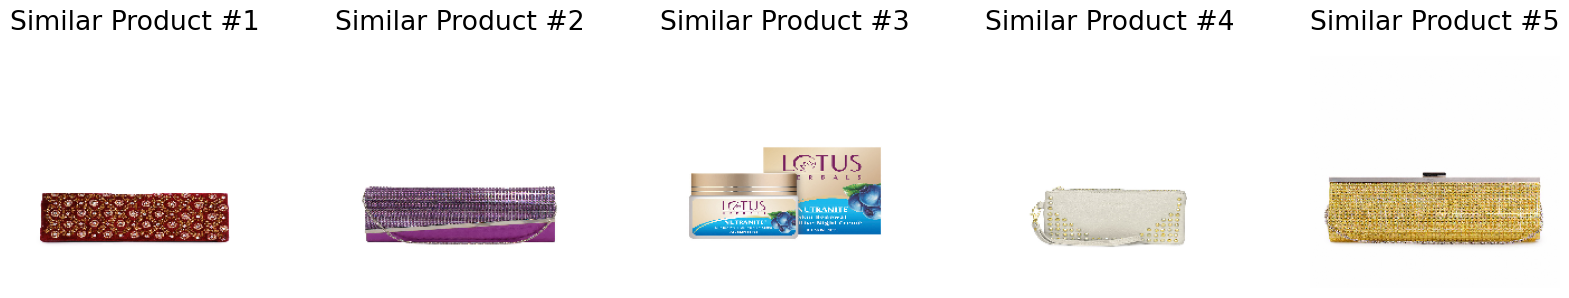

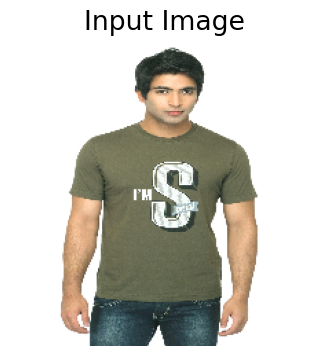

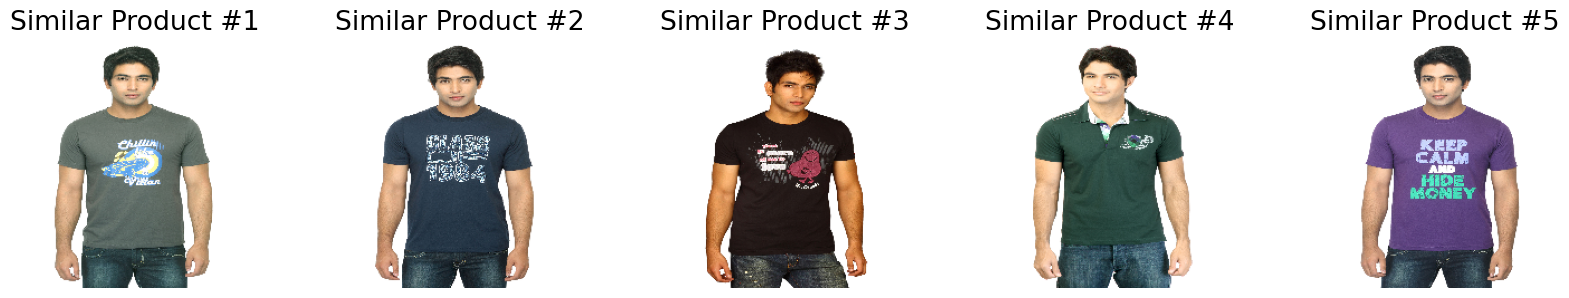

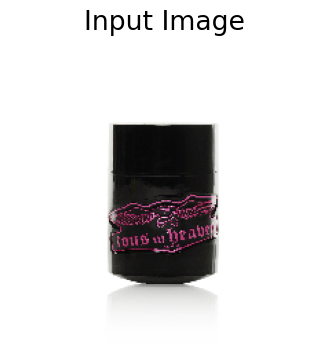

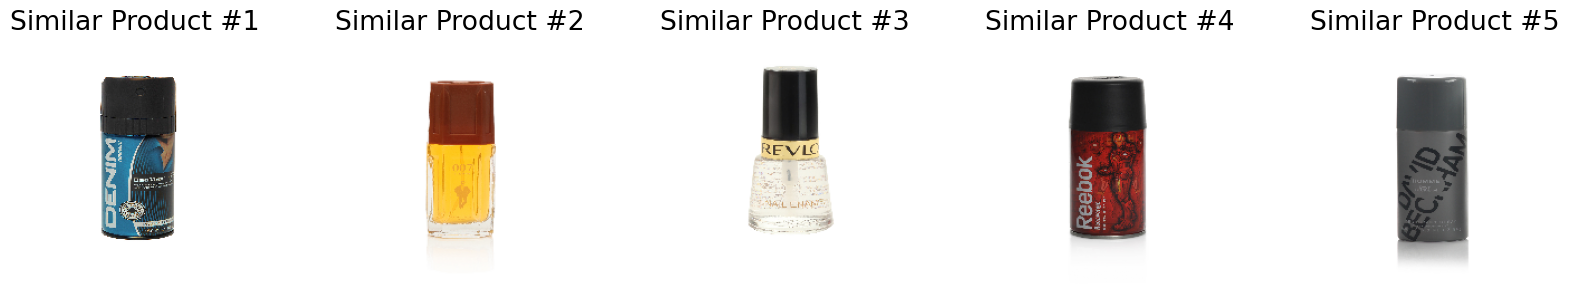

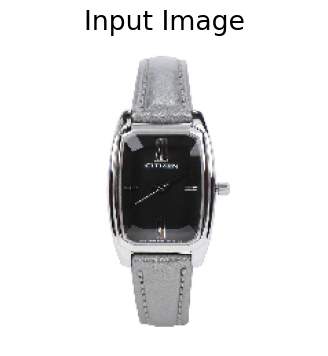

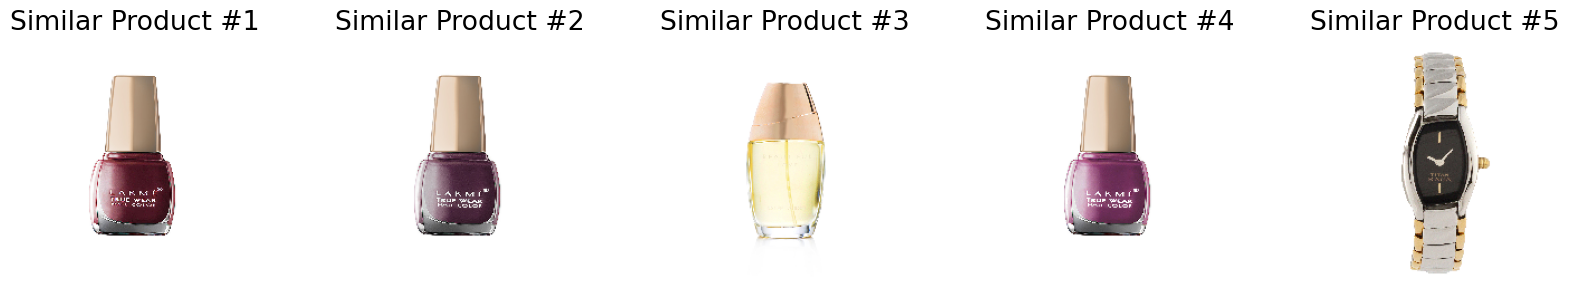

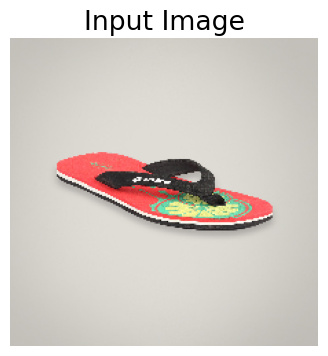

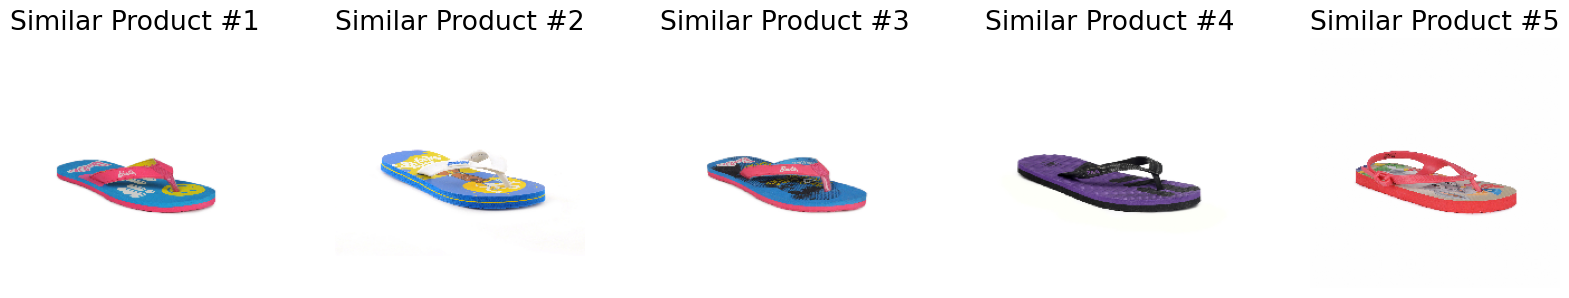

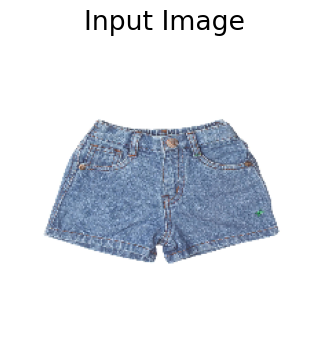

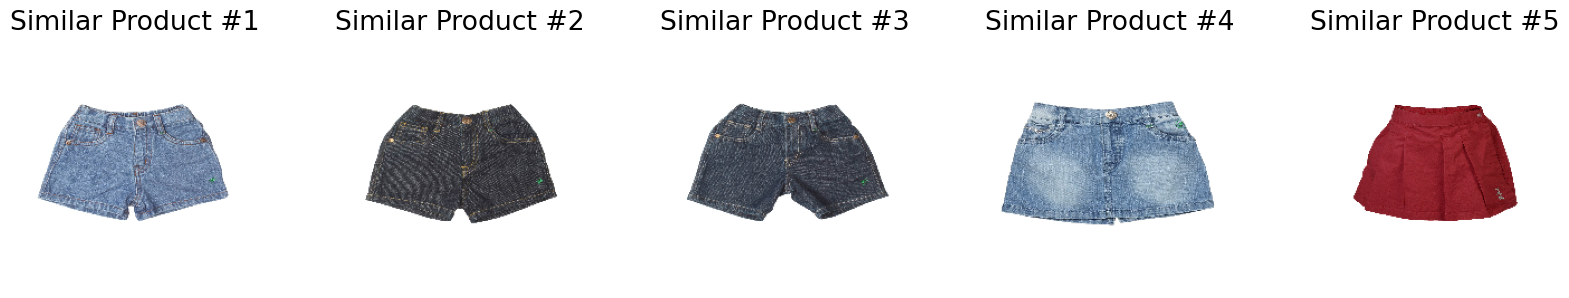

In [23]:
for _ in range(10):
    i = random.randint(0,len(styles_df))
    img1 = read_img(styles_df.loc[i,'filename'])
    dist, index = nearest_neighbors.kneighbors(X=X[i,:].reshape(1,-1))
    plt.figure(figsize = (4 , 4))
    plt.imshow(img1)
    plt.title("Input Image")
    plt.axis('off')
   
    plt.figure(figsize = (20 , 20))
    for i in range(1,6):
        plt.subplot(1 , 5, i)
        plt.subplots_adjust(hspace = 0.5 , wspace = 0.3)
        image = read_img(styles_df.loc[index[0][i],'filename'])
        plt.imshow(image)
        plt.title(f'Similar Product #{i}')
        plt.axis('off')

give reason as to why its similar based on observation